<div style="text-align:center">
    <h1>Supernovae times and locations</h1>
    <p style="text-align:center">FIRE (and other codes) currently assume that all supernova happen within their parent cluster and also end after 37.53 Myr. Let's investigate whether that is actually the case</p>
</div>

In [1]:
import cogsworth
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import gala.dynamics as gd

In [3]:
%config InlineBackend.figure_format = 'retina'
plt.style.use("default")


pd.options.display.max_columns = 999

plt.rc('font', family='serif')
plt.rcParams['text.usetex'] = False
fs = 24

# update various fontsizes to match
params = {'figure.figsize': (12, 8),
          'legend.fontsize': fs,
          'axes.labelsize': fs,
          'xtick.labelsize': 0.9 * fs,
          'ytick.labelsize': 0.9 * fs,
          'axes.linewidth': 1.1,
          'xtick.major.size': 7,
          'xtick.minor.size': 4,
          'ytick.major.size': 7,
          'ytick.minor.size': 4}
plt.rcParams.update(params)

# Load the population

In [4]:
p = cogsworth.pop.load("/mnt/home/twagg/ceph/pops/supernovae/vir_1.0-ce_1.0")

## Mark any problematic double supernova counts

In [5]:
%%time
uni, counts = np.unique(p.bpp[p.bpp["evol_type"] == 15]["bin_num"], return_counts=True)
x = uni[counts > 1]
uni, counts = np.unique(p.bpp[p.bpp["evol_type"] == 16]["bin_num"], return_counts=True)
y = uni[counts > 1]
p.avoid_these = np.concatenate((x, y))
print(len(x), len(y))
    # ce_pops[ce] = ce_pops[ce][~np.isin(ce_pops[ce].bin_nums, np.concatenate((x, y)))]

0 2
CPU times: user 812 ms, sys: 56.9 ms, total: 869 ms
Wall time: 762 ms


In [6]:
%%time
p.orbits

CPU times: user 3min 48s, sys: 43 s, total: 4min 31s
Wall time: 5min 37s


array([<Orbit cartesian, dim=3, shape=(201,)>,
       <Orbit cartesian, dim=3, shape=(201,)>,
       <Orbit cartesian, dim=3, shape=(201,)>, ...,
       <Orbit cartesian, dim=3, shape=(263,)>,
       <Orbit cartesian, dim=3, shape=(263,)>,
       <Orbit cartesian, dim=3, shape=(263,)>], dtype=object)

# Supernova locations

Okay now let's look at where these supernovae actually go off

## Prep star particles

In [6]:
%%time
star_particles = pd.read_hdf("FIRE_star_particles.h5")
try:
    particle_orbits = np.load("particle_orbits.npy", allow_pickle=True)
except:
    particle_orbits = [None for _ in range(len(star_particles))]
    for i in range(len(star_particles)):
        if i % 1000 == 0:
            print(i)
        w0 = gd.PhaseSpacePosition(pos=star_particles.iloc[i][["x", "y", "z"]].values * u.kpc,
                                vel=star_particles.iloc[i][["v_x", "v_y", "v_z"]].values * u.km / u.s)
        min_dt = (p.max_ev_time - star_particles.iloc[i]["t_form"] * u.Gyr).to(u.Myr).value
        if min_dt <= 0.01:
            continue
        particle_orbits[i] = p.galactic_potential.integrate_orbit(w0,
                                                                  t1=star_particles.iloc[i]["t_form"] * u.Gyr,
                                                                  t2=p.max_ev_time,
                                                                  dt=min(min_dt - 0.01, 1) * u.Myr)
    np.save("particle_orbits.npy", particle_orbits)

CPU times: user 966 ms, sys: 174 ms, total: 1.14 s
Wall time: 1.15 s


## Attach distances and masks

In [69]:
f = np.load(f"/mnt/home/twagg/ceph/pops/supernovae/sn_positions-vir_1.0-ce_1.0.npz")
p.primary_sn_distances, p.secondary_sn_distances = f["arr_0"] * u.kpc, f["arr_1"] * u.kpc

In [9]:
def subpop_masks(p):
    sn_rows = p.bpp[((p.bpp["evol_type"] == 15) | (p.bpp["evol_type"] == 16)) & ~p.bpp["bin_num"].isin(p.avoid_these)]
    sn_initC = p.initC.loc[sn_rows["bin_num"]]
    single_bin_nums = sn_initC[sn_initC["kstar_2"] == 15].index.values
    
    primary_sn_rows = sn_rows[sn_rows["evol_type"] == 15]
    secondary_sn_rows = sn_rows[sn_rows["evol_type"] == 16]

    p.sn_singles = primary_sn_rows["bin_num"].isin(single_bin_nums)
    
    sn_1_sep_zero = primary_sn_rows["bin_num"].isin(primary_sn_rows["bin_num"][primary_sn_rows["sep"] == 0.0])
    p.sn_1_merger = ~p.sn_singles & sn_1_sep_zero
    p.sn_1 = ~p.sn_singles & ~sn_1_sep_zero
    
    sn_2_sep_zero = secondary_sn_rows["bin_num"].isin(secondary_sn_rows["bin_num"][secondary_sn_rows["sep"] == 0.0])
    p.sn_2_merger = sn_2_sep_zero
    p.sn_2 = ~sn_2_sep_zero
    
    print(p.sn_singles.sum(), p.sn_1.sum(), p.sn_2.sum(), p.sn_1_merger.sum() + p.sn_2_merger.sum())
    
    return p.sn_singles, p.sn_1, p.sn_1_merger, p.sn_2, p.sn_2_merger

In [10]:
subpop_masks(p);

448402 256442 167605 313495


## Fiducial simulation

In [71]:
def sn_distance_histograms(p, bins=np.geomspace(1e0, 1e4, 500), fig=None, axes=None, show=True):
    if fig is None or axes is None:
        fig, axes = plt.subplots(2, 1, figsize=(12, 14))

    bin_centres = np.array([(bins[i] + bins[i + 1]) / 2. for i in range(len(bins) - 1)])
    widths = np.insert(bin_centres[1:] - bin_centres[:-1], -1, bin_centres[1] - bin_centres[0])

    ax = axes[0]
    ax.hist([p.primary_sn_distances.to(u.pc).value[p.sn_singles],
             p.primary_sn_distances.to(u.pc).value[p.sn_1],
             p.secondary_sn_distances.to(u.pc).value[p.sn_2],
             np.concatenate((p.primary_sn_distances.to(u.pc).value[p.sn_1_merger], p.secondary_sn_distances.to(u.pc).value[p.sn_2_merger]))],
            bins=bins, label=["Single", "Primary", "Secondary", "Merger Product"], stacked=True,
            color=["grey", plt.cm.viridis(0.4), plt.cm.viridis(0.7), "gold"]);
    ax.legend(fontsize=0.7*fs)
    ax.set_ylabel(ylabel="Number of SN")

    ax = axes[1]
    phist, bins = np.histogram(p.primary_sn_distances.to(u.pc).value, bins=bins)
    shist, bins = np.histogram(p.secondary_sn_distances.to(u.pc).value, bins=bins)
    hist = phist + shist
    ax.bar(bin_centres, 1 - np.cumsum(hist) / np.sum(hist), width=widths, color="#c78ee6")
    ax.set_yscale("log")
    ax.set_ylabel(r"Fraction of SNe > $d$")

    for ax in axes:
        ax.set(xscale="log", xlabel="SN distance from parent cluster [pc]")
        ax.grid(linewidth=0.5, color="lightgrey")

    if show:
        plt.show()
    return fig, axes

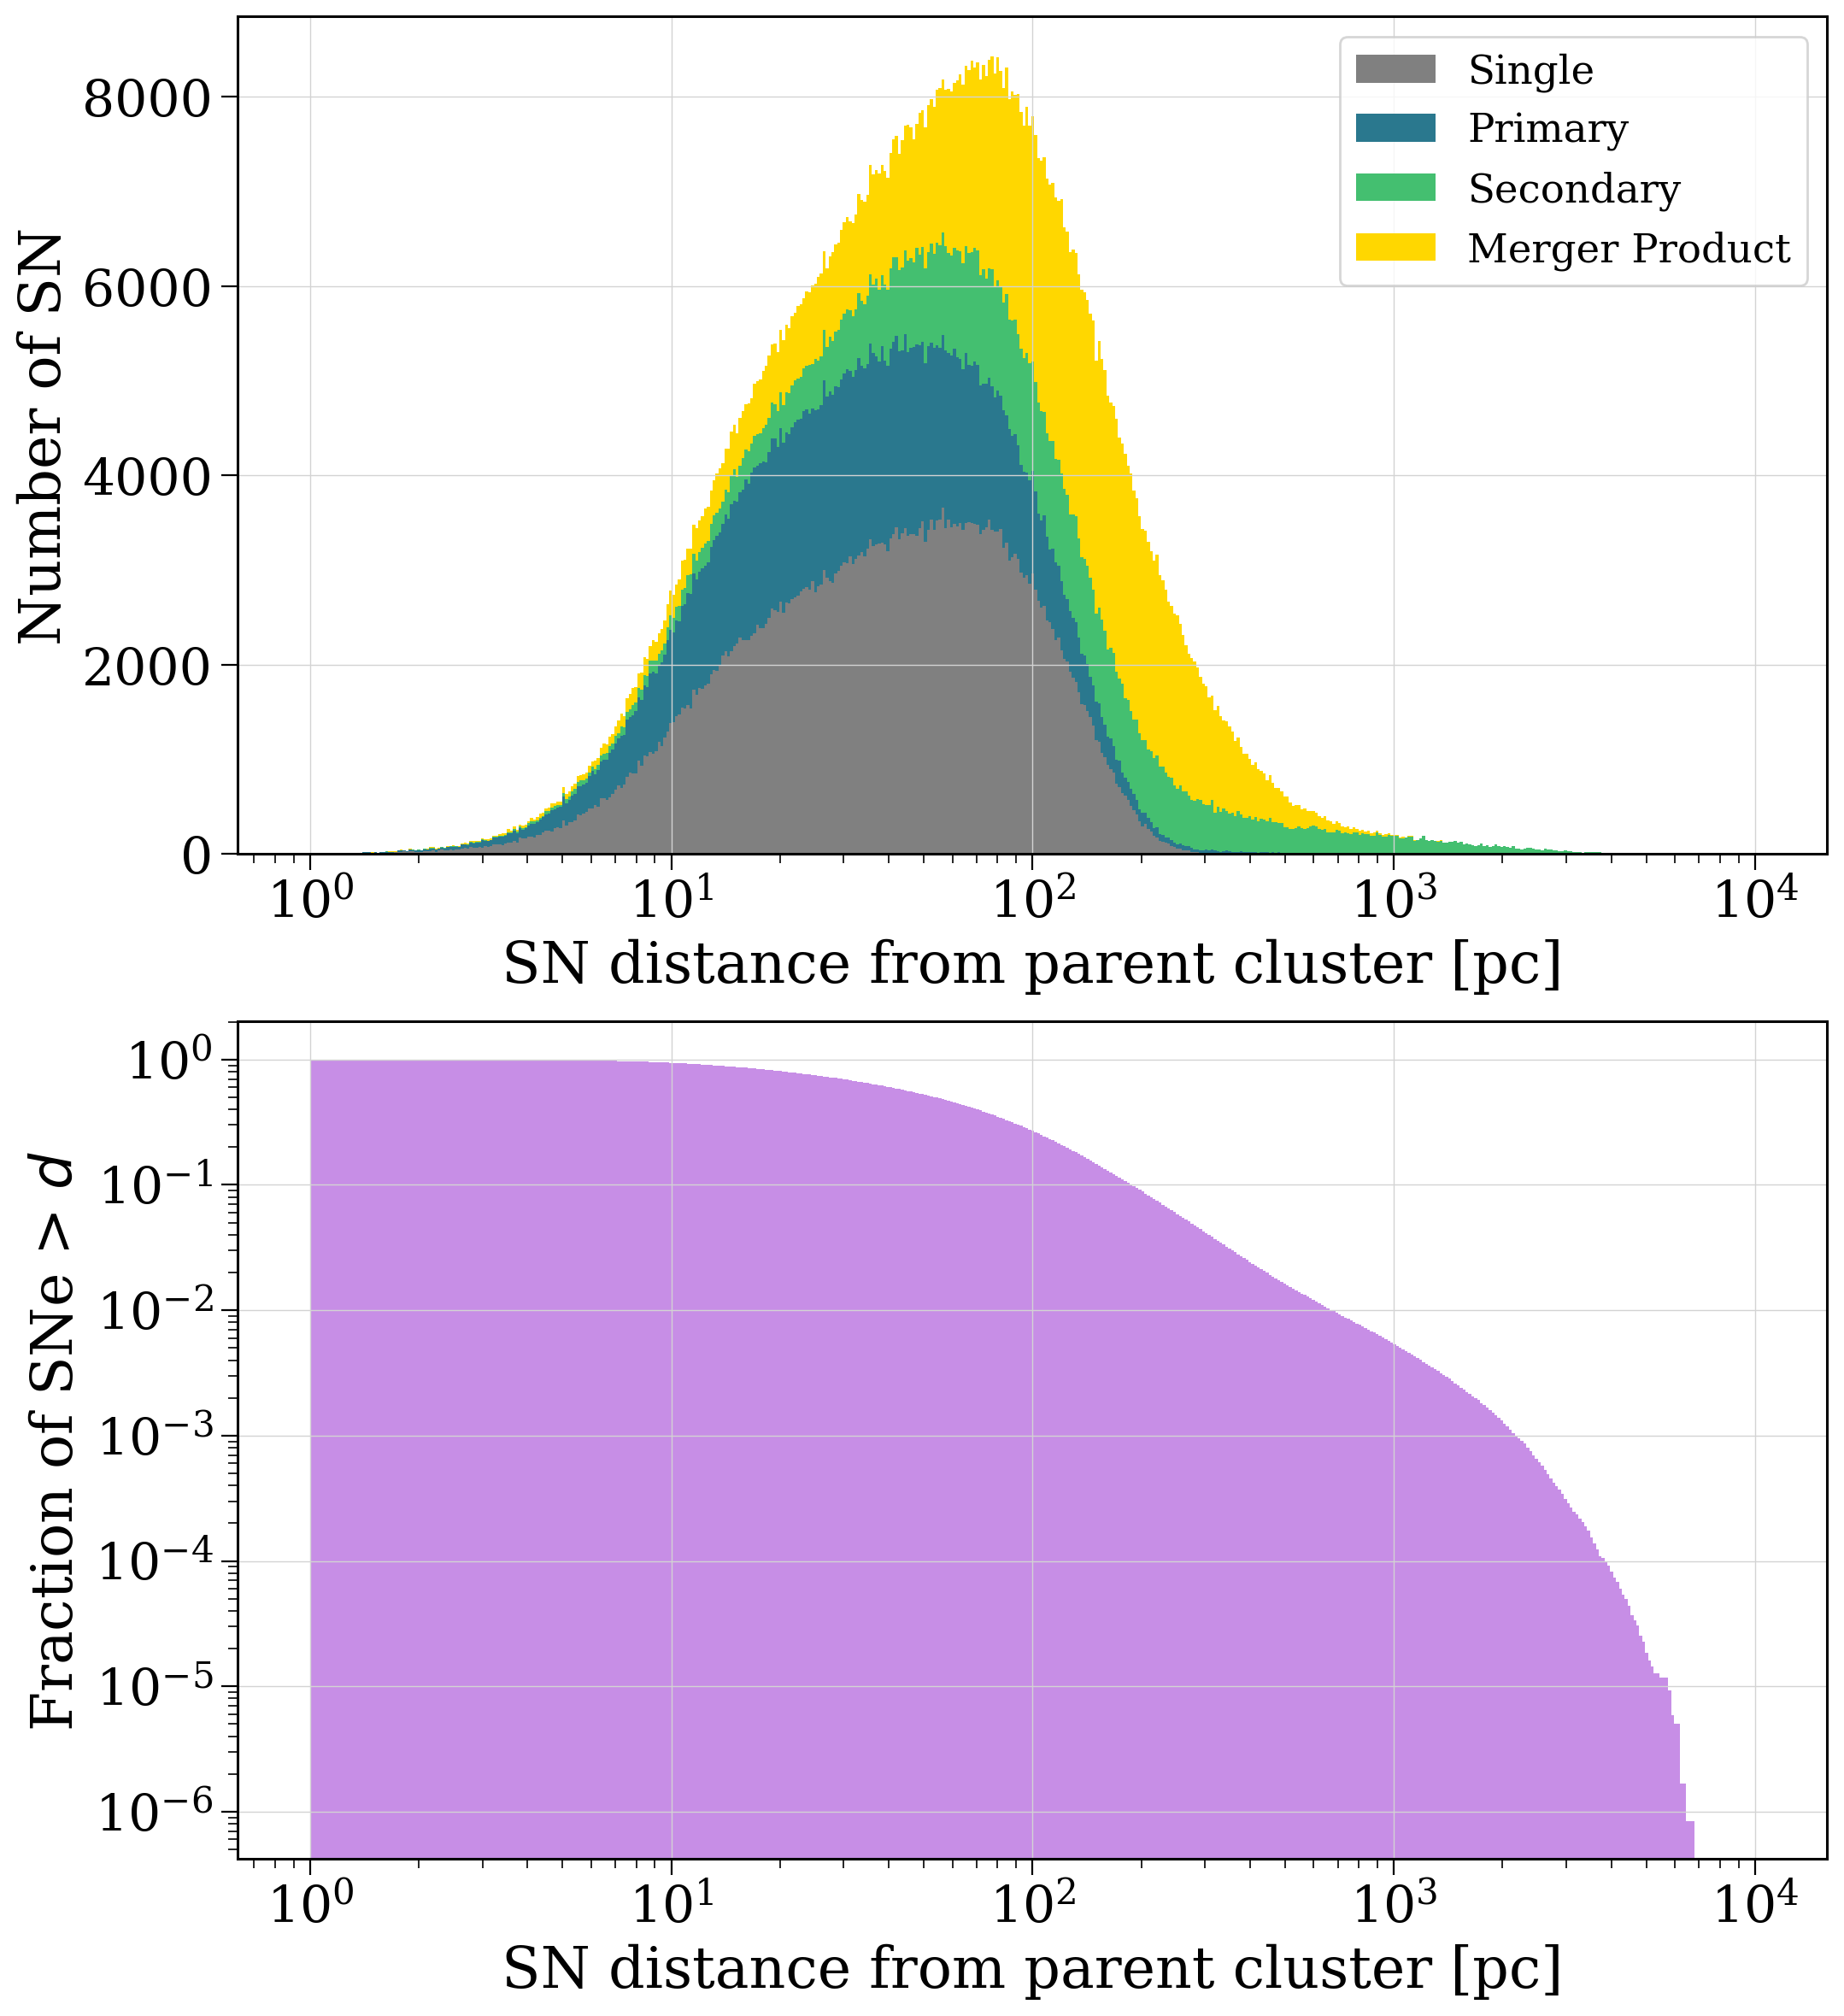

(<Figure size 1200x1400 with 2 Axes>,
 array([<Axes: xlabel='SN distance from parent cluster [pc]', ylabel='Number of SN'>,
        <Axes: xlabel='SN distance from parent cluster [pc]', ylabel='Fraction of SNe > $d$'>],
       dtype=object))

In [72]:
sn_distance_histograms(p)

## Time animations

In [13]:
from matplotlib import animation

In [14]:
plt.rcParams["animation.html"] = "jshtml"

In [21]:
sn_1_bn = p.bpp[(p.bpp["evol_type"] == 15) & ~p.bpp["bin_num"].isin(p.avoid_these)]["bin_num"]

In [35]:
sn_1_rows = p.bpp[(p.bpp["evol_type"] == 15) & ~p.bpp["bin_num"].isin(p.avoid_these)]

0.014058914259433212 kpc
14.058914259433212 pc


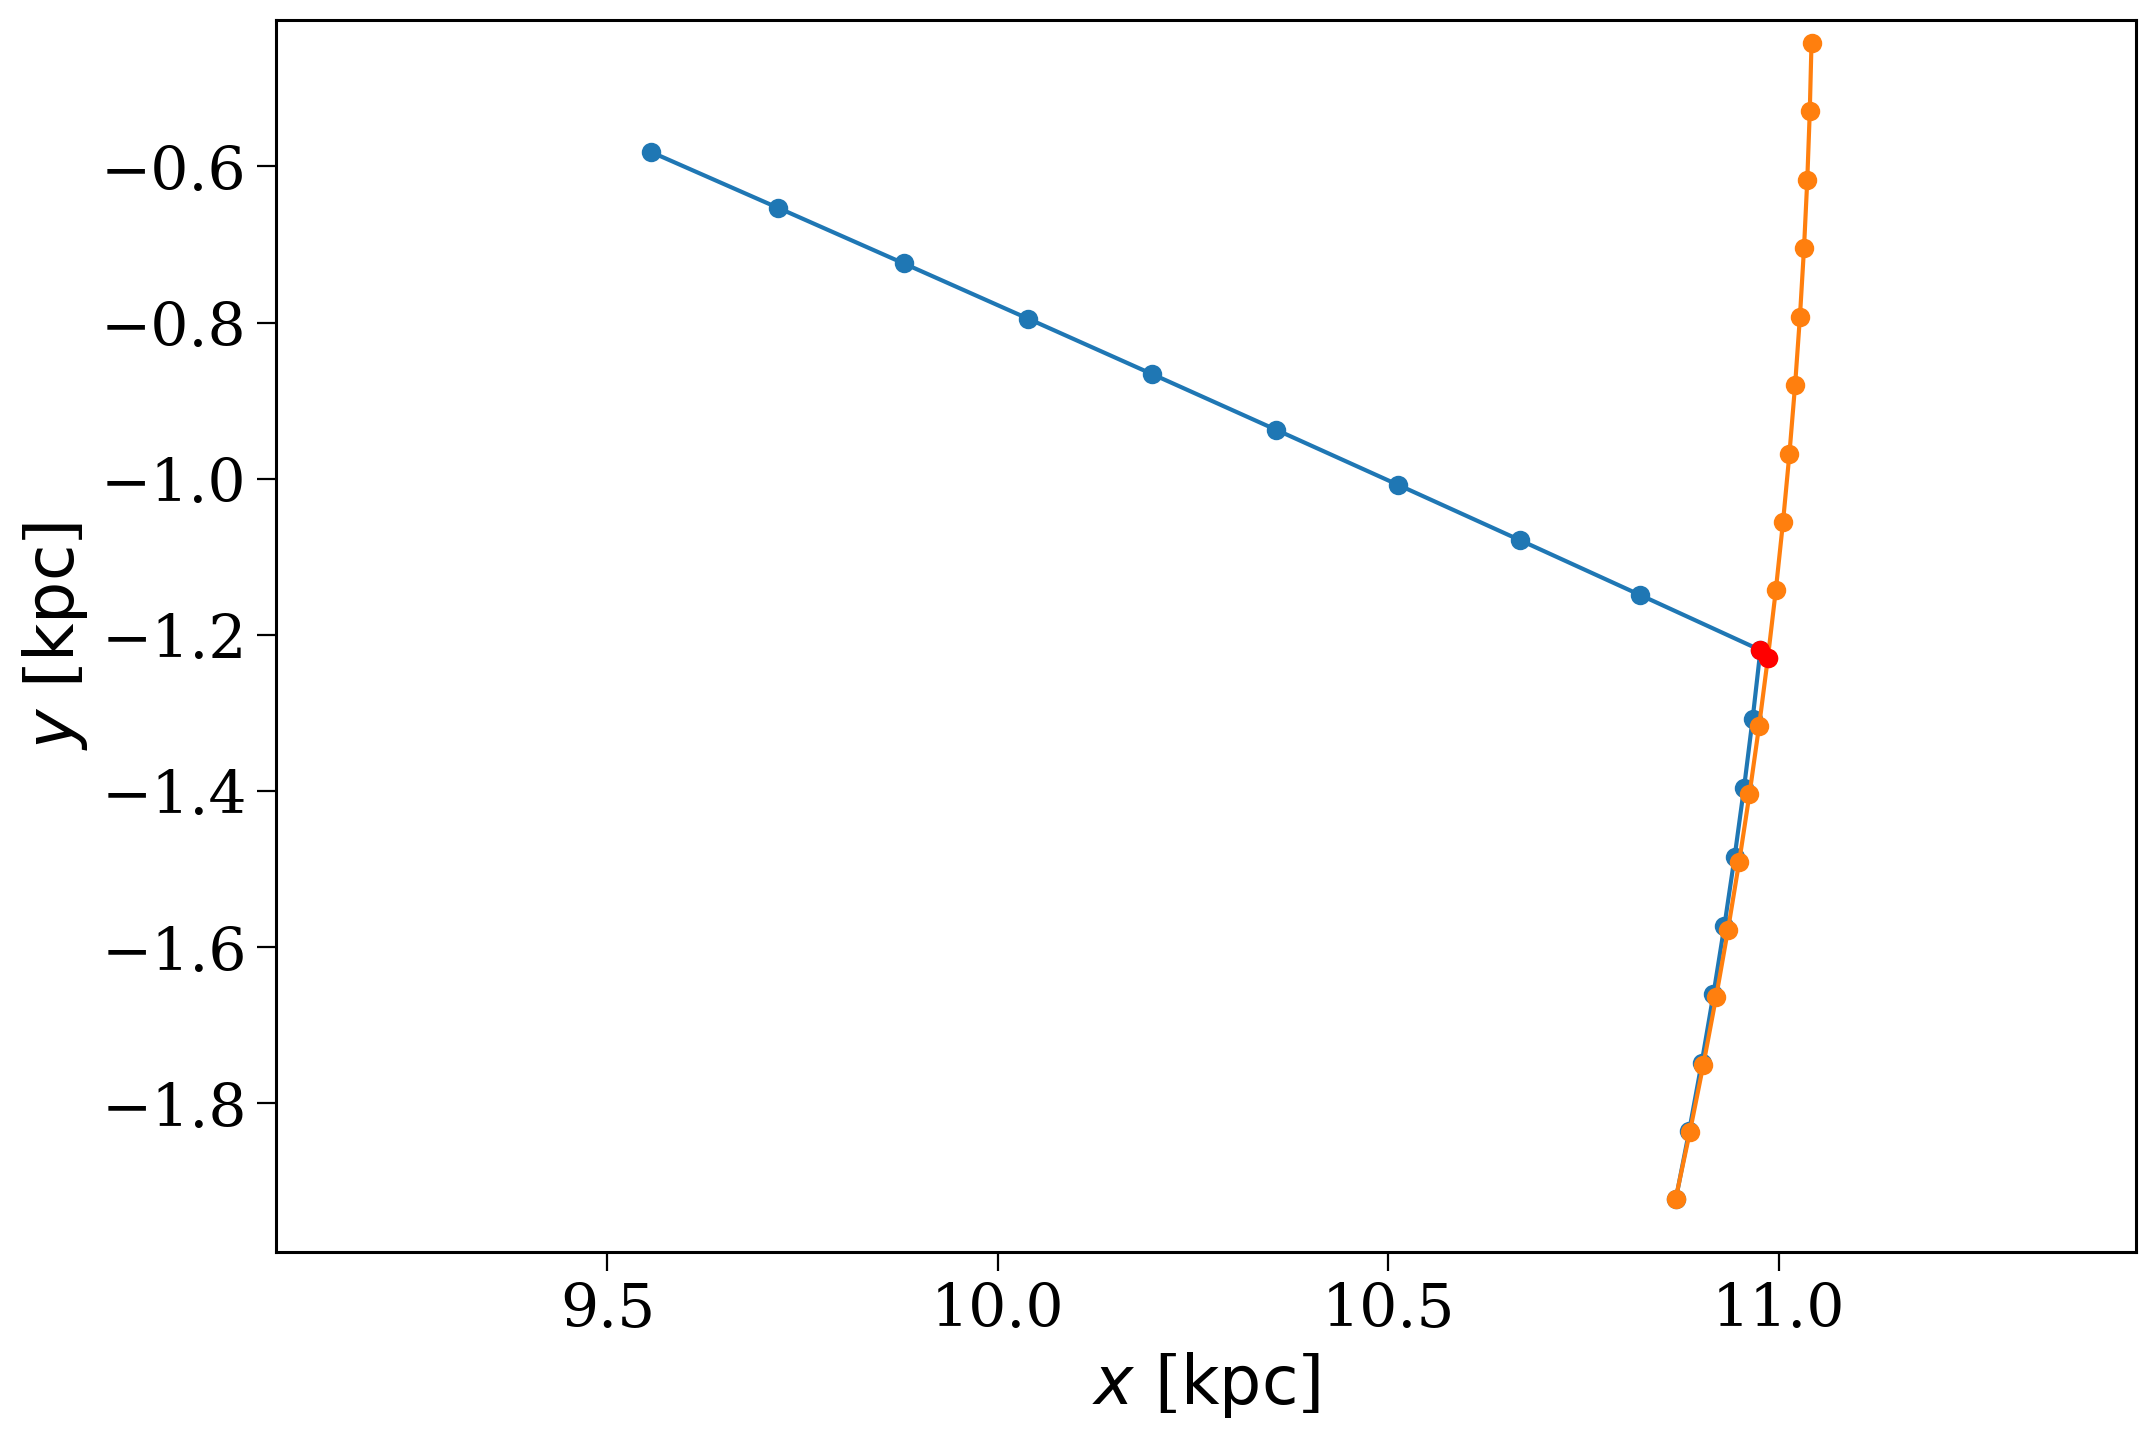

In [70]:
def check_orbit_direct(orbit, sn_time, est_dist, particle_orbit):
    orbit = orbit[:np.ceil(sn_time * 2).astype(int)]
    particle_orbit = particle_orbit[:np.ceil(sn_time * 2).astype(int)]
    fig, ax = plt.subplots()
    
    orbit.plot(['x', 'y'], axes=[ax], marker='o', label="Star")
    particle_orbit.plot(['x', 'y'], axes=[ax], marker='o', label="Cluster")
    
    star_at_sn = orbit[np.argmin(np.abs((orbit.t - orbit.t[0]).to(u.Myr).value - sn_time))]
    cluster_at_sn = particle_orbit[np.argmin(np.abs((particle_orbit.t - particle_orbit.t[0]).to(u.Myr).value - sn_time))]
    
    star_at_sn = orbit[(orbit.t - orbit.t[0]).to(u.Myr).value < sn_time][-1]
    cluster_at_sn = particle_orbit[(particle_orbit.t - particle_orbit.t[0]).to(u.Myr).value < sn_time][-1]
    
    print(np.sqrt(np.sum((star_at_sn.pos.xyz - cluster_at_sn.pos.xyz)**2, axis=0)))
    
    ax.scatter(star_at_sn.x, star_at_sn.y, color="red", zorder=10)
    ax.scatter(cluster_at_sn.x, cluster_at_sn.y, color="red", zorder=10)
    
    print(est_dist)
    
    plt.show()
    
def check_orbit(bin_num):
    check_orbit_direct(p.primary_orbits[p.bin_nums == bin_num][0], sn_1_rows.loc[bin_num]["tphys"],
                       p.primary_sn_distances[sn_1_rows["bin_num"] == bin_num][0].to(u.pc), particle_orbits[int(p.initC.loc[bin_num]["particle_id"])])
check_orbit(2) 

In [23]:
sn_1_bn[(p.primary_sn_distances > 100 * u.pc) & (sn_times_1 < 10)].values

array([      2,      12,      21, ..., 2161077, 2161101, 2161120])

0
0
0
0
2
4
6
8
10
12
14
16
18
20
22
24
26
28
30
32
34
36
38
40
42
44
46
48
50
52
54
56
58
60
80
100
120
140
160
180
200


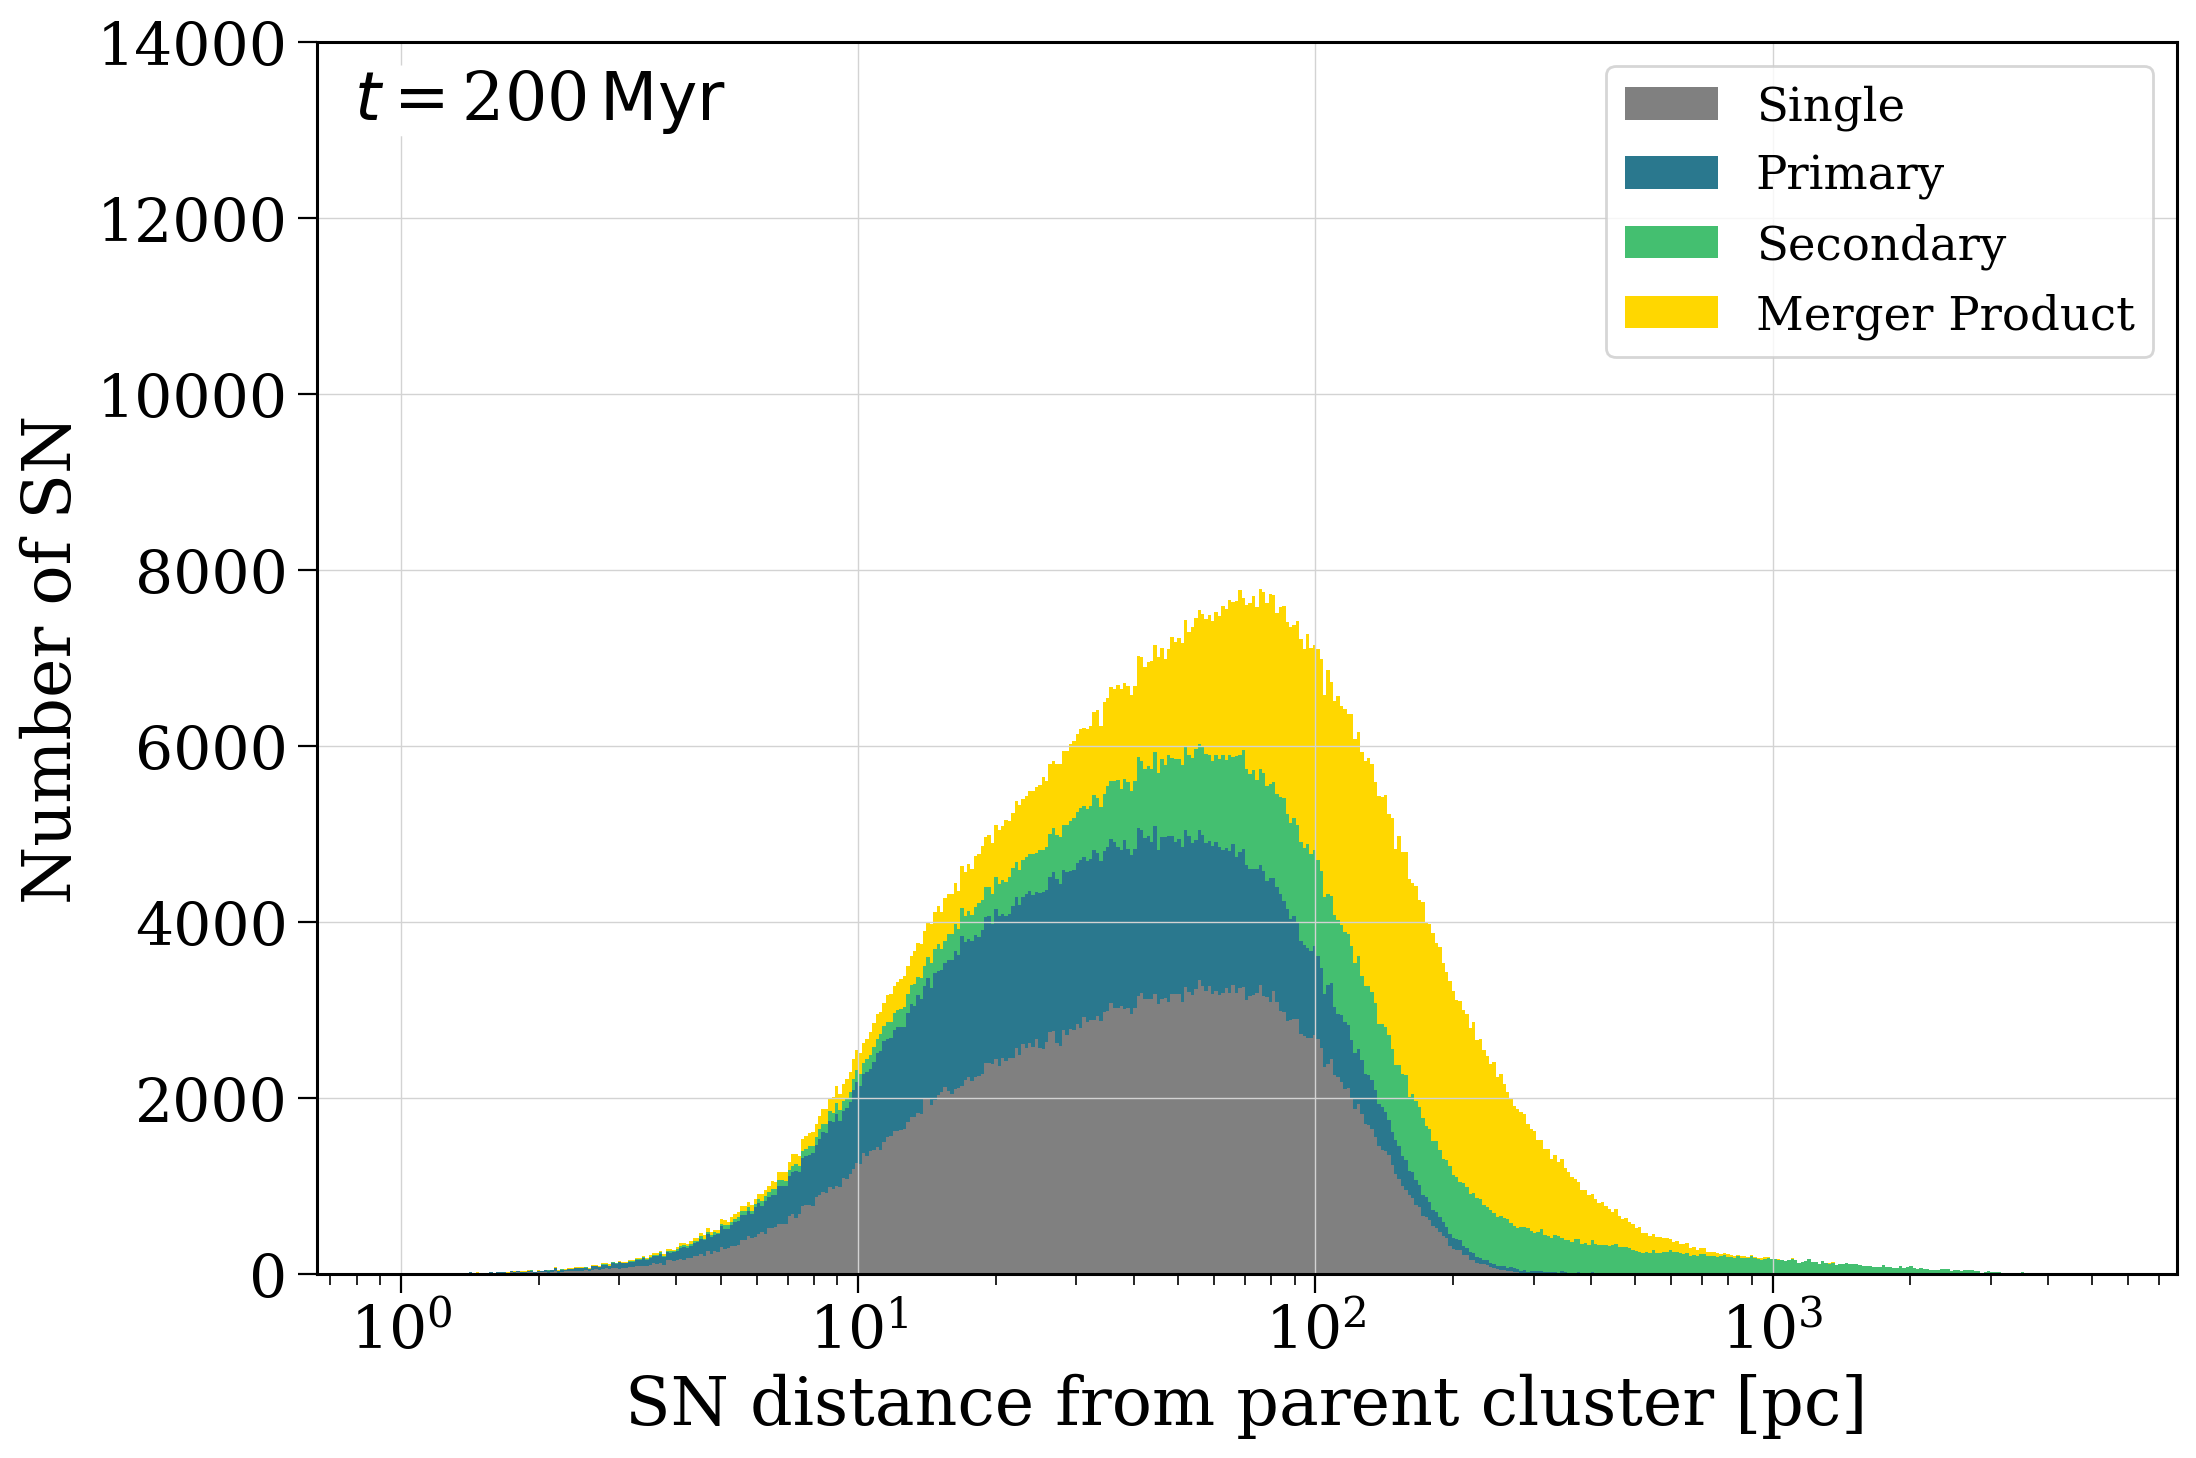

In [73]:
sn_times_1 = p.bpp[(p.bpp["evol_type"] == 15) & ~p.bpp["bin_num"].isin(p.avoid_these)]["tphys"].values
sn_times_2 = p.bpp[(p.bpp["evol_type"] == 16) & ~p.bpp["bin_num"].isin(p.avoid_these)]["tphys"].values
bins = np.geomspace(1e0, 5e3, 500)

frames = np.concatenate((np.arange(0, 60 + 2, 2), np.arange(80, 200 + 20, 20)))

def time_evolve_distances(bar_container, t_label):
    def animate(frame_number):
        print(frame_number)
        time_valid_1 = sn_times_1 < frame_number
        time_valid_2 = sn_times_2 < frame_number
        
        t_label.set_text(r"$t = $" + str(frame_number) + r"$ \, {\rm Myr}$")
        
        data = [
            p.primary_sn_distances.to(u.pc).value[p.sn_singles & time_valid_1],
            p.primary_sn_distances.to(u.pc).value[p.sn_1 & time_valid_1],
            p.secondary_sn_distances.to(u.pc).value[p.sn_2 & time_valid_2],
            np.concatenate((p.primary_sn_distances.to(u.pc).value[p.sn_1_merger & time_valid_1],
                            p.secondary_sn_distances.to(u.pc).value[p.sn_2_merger & time_valid_2]))
        ]
        
        ns = np.array([np.histogram(d, bins)[0] for d in data])
        ys = np.zeros_like(ns)
        for i in range(1, len(ns)):
            ys[i] = np.sum(ns[:i, :], axis=0)
        for i in range(len(data)):
            for count, rect, y in zip(ns[i], bar_container[i].patches, ys[i]):
                rect.set_height(count)
                rect.set_y(y)
        return np.concatenate([bc.patches for bc in bar_container])
    return animate

fig, ax = plt.subplots()

bar_container = ax.hist([p.primary_sn_distances.to(u.pc).value[p.sn_singles],
                         p.primary_sn_distances.to(u.pc).value[p.sn_1],
                         p.secondary_sn_distances.to(u.pc).value[p.sn_2],
                         np.concatenate((p.primary_sn_distances.to(u.pc).value[p.sn_1_merger], p.secondary_sn_distances.to(u.pc).value[p.sn_2_merger]))],
                        bins=bins, label=["Single", "Primary", "Secondary", "Merger Product"], stacked=True,
                        color=["grey", plt.cm.viridis(0.4), plt.cm.viridis(0.7), "gold"])[-1]
ax.legend(fontsize=0.7*fs)
ax.set_ylabel(ylabel="Number of SN")
ax.set(xscale="log", xlabel="SN distance from parent cluster [pc]")
ax.grid(linewidth=0.5, color="lightgrey")
ax.set_ylim(top=14000)
t_label = ax.annotate(r"$t = 0 {\rm Myr}$", xy=(0.02, 0.98), xycoords="axes fraction", va="top",
                      bbox=dict(boxstyle="round", fc="white", ec="white", pad=0.0),
                      fontsize=fs)


ani = animation.FuncAnimation(fig, time_evolve_distances(bar_container, t_label), frames,
                              repeat=False, blit=True)
ani

In [20]:
bad_nums = p.bpp[(p.bpp["evol_type"] == 15)
                 & ~p.bpp["bin_num"].isin(p.avoid_these)]["bin_num"].values[((p.primary_sn_distances > 100 * u.pc)
                                                                             & (sn_times_1 < 5))]
bad_nums

array([     92,     168,     232, ..., 2165409, 2165453, 2165567])

In [23]:
bad_distances = p.primary_sn_distances[((p.primary_sn_distances > 100 * u.pc) & (sn_times_1 < 5))].to(u.pc)

In [21]:
p.bpp.loc[bad_nums[0]]

tphys     mass_1     mass_2  kstar_1  kstar_2           sep  \
92    0.000000  56.823164  33.827069      1.0      1.0  11354.390976   
92    4.120487  43.742501  31.754131      2.0      1.0  13634.253051   
92    4.125613  43.185806  31.757529      4.0      1.0  13727.229456   
92    4.297169  17.478669  34.978500      7.0      1.0  13124.032066   
92    4.640503  10.856719  34.660488      8.0      1.0  15127.124122   
92    4.664514  10.496111  34.639712      8.0      1.0  15255.162453   
92    4.664514   6.692940  34.639712     14.0      1.0     -1.000000   
92    5.346654   6.692940  33.244377     14.0      2.0     -1.000000   
92    5.353595   6.692940  33.134229     14.0      4.0     -1.000000   
92    5.691609   6.692940  12.754548     14.0      7.0     -1.000000   
92    5.941505   6.692940   9.839254     14.0      8.0     -1.000000   
92    5.968610   6.692940   9.507981     14.0      8.0     -1.000000   
92    5.968610   6.692940   5.318535     14.0     14.0     -1.000000   
92  200.880562   6.692940   5.318535     14.0     14.0     -1.000000   

            porb       ecc    RRLO_1    RRLO_2  evol_type        aj_1  \
92  14727.650381  0.468619  0.004606  0.004154        1.0    0.000000   
92  21235.153109  0.468619  0.012764  0.006171        2.0    4.475150   
92  21531.782878  0.468516  0.647874  0.006120        2.0    4.480276   
92  24058.616877  0.319901  0.000481  0.004628        2.0    0.162096   
92  31960.893704  0.319901  0.000337  0.004290        2.0    0.610809   
92  32503.994278  0.319901  0.000337  0.004290       15.0    0.634457   
92     -1.000000 -1.000000  0.000000 -2.000000       11.0    0.634457   
92     -1.000000 -1.000000  0.000100  0.000100        2.0    0.682140   
92     -1.000000 -1.000000  0.000100  0.000100        2.0    0.689081   
92     -1.000000 -1.000000  0.000100  0.000100        2.0    1.027095   
92     -1.000000 -1.000000  0.000100  0.000100        2.0    1.276991   
92     -1.000000 -1.000000  0.000100  0.000100       16.0    1.304096   
92     -1.000000 -1.000000  0.000100  0.000100        2.0    1.304096   
92     -1.000000 -1.000000  0.000100  0.000100       10.0  196.216048   

          aj_2         tms_1         tms_2    massc_1    massc_2        rad_1  \
92    0.000000  3.948477e+00  5.273949e+00   0.000000   0.000000    11.796193   
92    4.234185  4.475150e+00  5.530910e+00  15.797396   0.000000    37.629542   
92    4.238959  4.475150e+00  5.530450e+00  16.113319   0.000000  1918.070065   
92    4.110674  4.579490e-01  5.148976e+00   0.000000   0.000000     1.377271   
92    4.481755  6.108083e-01  5.182360e+00   7.505747   0.000000     0.985296   
92    4.507290  6.108083e-01  5.184537e+00   8.032604   0.000000     1.085780   
92    4.507290  6.108083e-01  5.184537e+00   8.032604   0.000000     1.085780   
92    5.341747  1.000000e+10  5.341747e+00   6.692940  10.904832     0.000028   
92    5.348688  1.000000e+10  5.341747e+00   6.692940  11.122917     0.000028   
92    0.321774  1.000000e+10  5.512275e-01   6.692940   0.000000     0.000028   
92    0.652680  1.000000e+10  6.526791e-01   6.692940   6.728081     0.000028   
92    0.679745  1.000000e+10  6.526791e-01   6.692940   7.254830     0.000028   
92    0.000000  1.000000e+10  6.526791e-01   6.692940   5.318535     0.000028   
92  194.911952  1.000000e+10  1.000000e+10   6.692940   5.318535     0.000028   

          rad_2    mass0_1    mass0_2         lum_1         lum_2  \
92     8.396131  56.823164  33.827069  4.612814e+05  1.570882e+05   
92    15.717139  43.742501  31.754131  6.594975e+05  2.459724e+05   
92    15.744266  43.742501  31.757529  6.309748e+05  2.462575e+05   
92    18.176731  17.478669  34.978500  4.484255e+05  3.135144e+05   
92    21.254597  10.856719  34.660488  2.357219e+05  3.287530e+05   
92    21.531597  10.856719  34.639712  3.309117e+05  3.298836e+05   
92    21.531597  10.856719  34.639712  3.309117e+05  3.298836e+05   
92    26.871781  10.856719  33.244377  1.000000e-10  3.814427e+0

In [370]:
(100.10604 * u.pc / (4.664514 * u.Myr)).to(u.km / u.s)

<Quantity 20.98458859 km / s>

In [375]:
p.initial_galaxy

<Galaxy, size=2165527>

In [30]:
particle_orbits[0]

<Orbit cartesian, dim=3, shape=(201,)>

In [37]:
p.primary_orbits[p.bin_nums == 92][0][0].xyz.to(u.pc)

<Quantity [10867.62523408, -1921.67594537,   811.75554001] pc>

In [38]:
particle_orbits[0][0].xyz.to(u.pc)

<Quantity [10867.90383955, -1922.79154317,   811.396487  ] pc>

In [42]:
p.primary_orbits[p.bin_nums == 92][0][0].vel.d_xyz.to(u.km / u.s)

<Quantity [16.62671735, 85.79624888, 50.19426076] km / s>

In [43]:
particle_orbits[0][0].vel.d_xyz.to(u.km / u.s)

<Quantity [18.39496885, 84.08393292, 51.67745019] km / s>

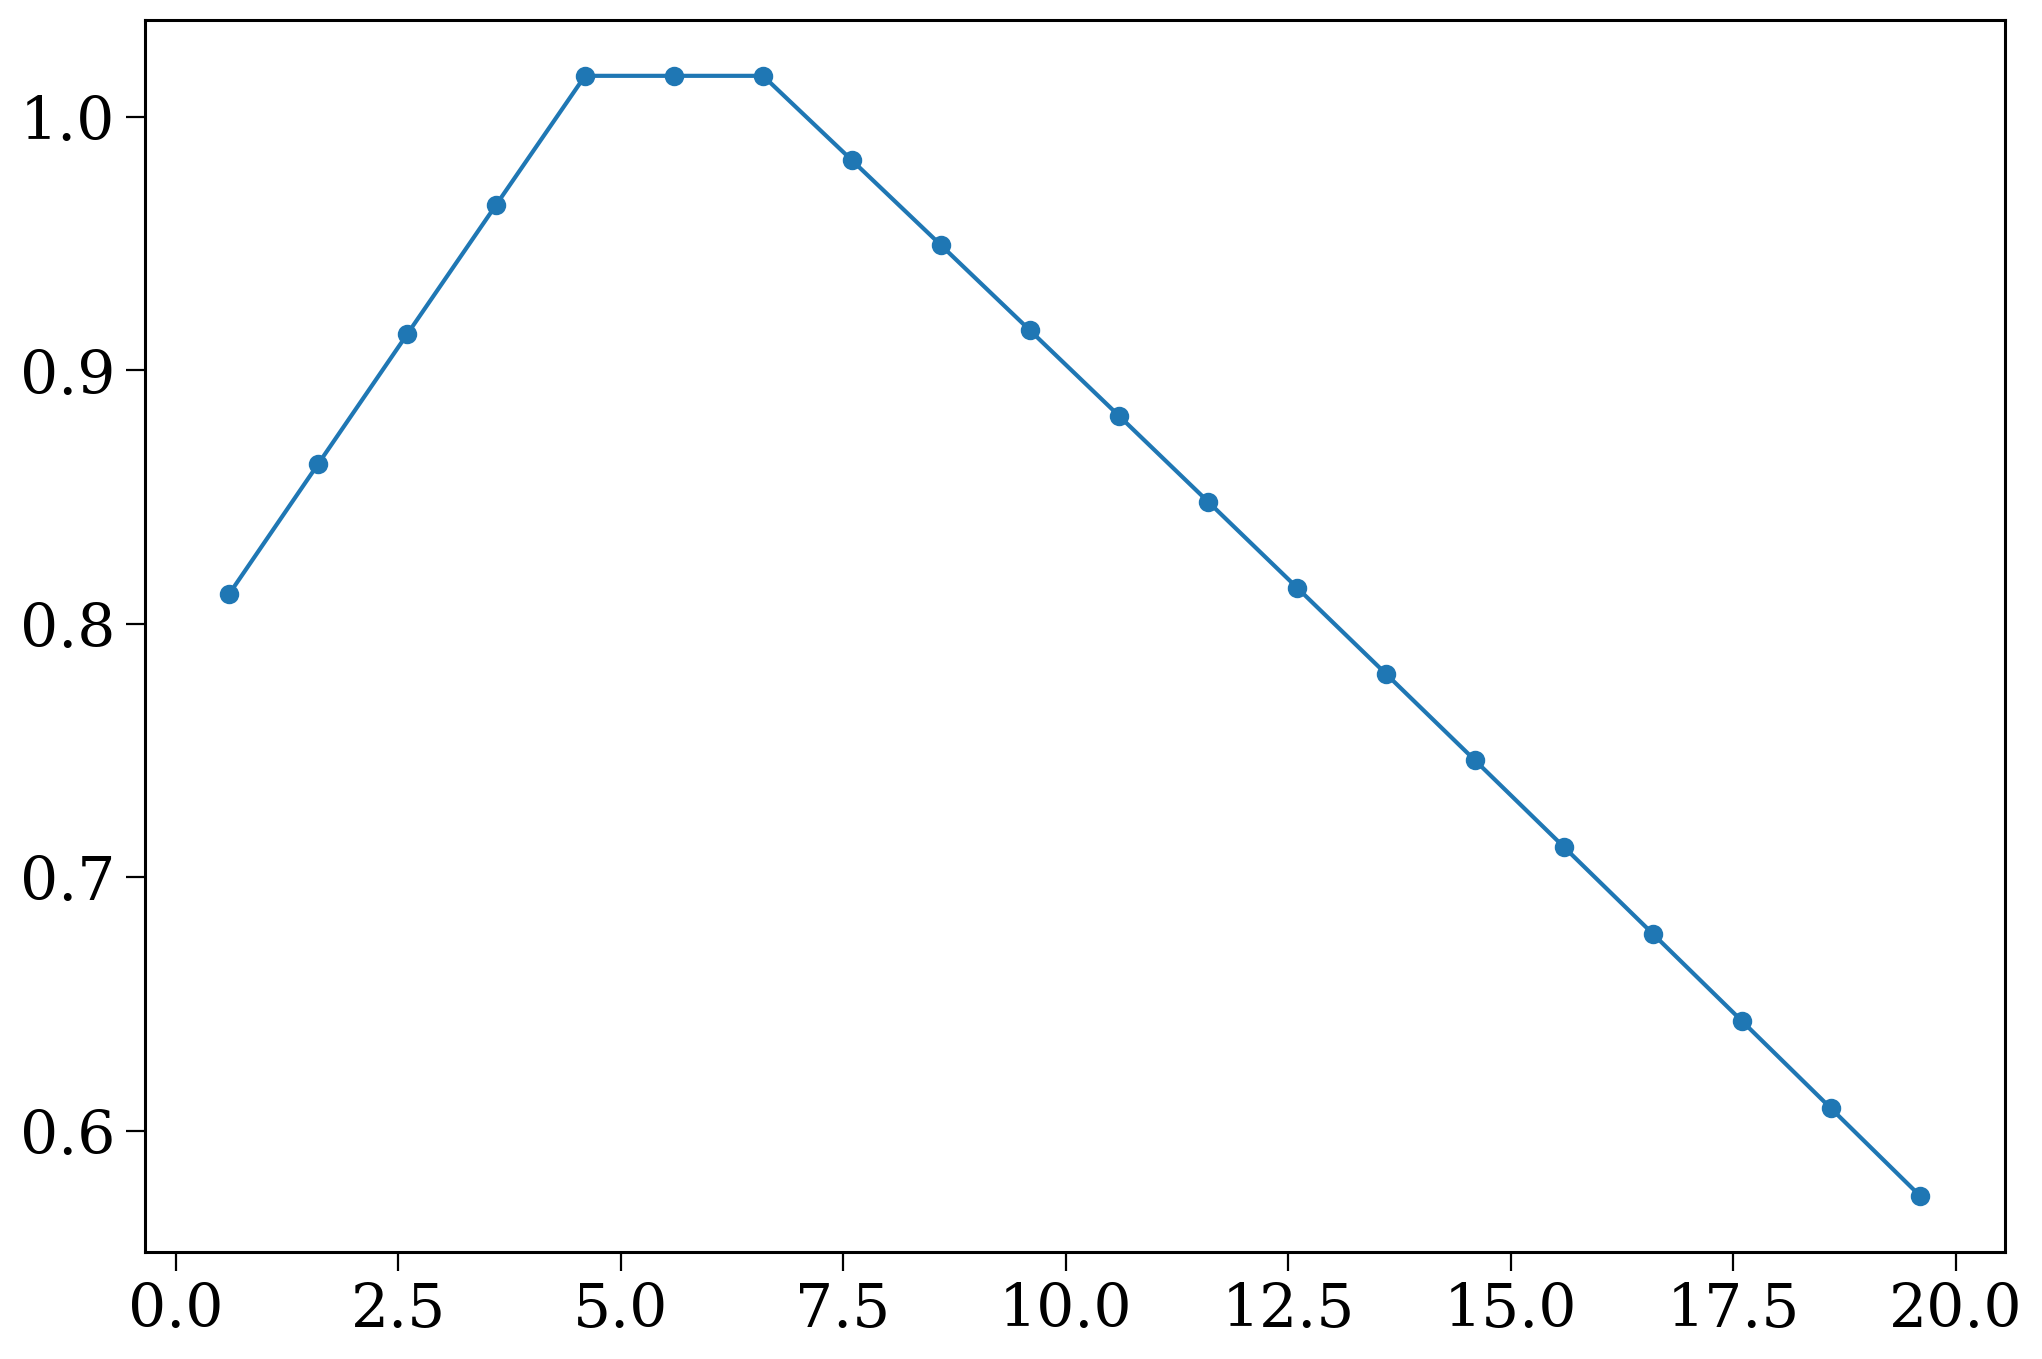

In [70]:
plt.plot(p.primary_orbits[p.bin_nums == 92][0].t[:20] - 13740 * u.Myr,
         p.primary_orbits[p.bin_nums == 92][0].pos.z[:20], marker="o")

In [63]:
p.primary_orbits[p.bin_nums == 92][0].t[:7]

<Quantity [13740.60041562, 13741.60041562, 13742.60041562, 13743.60041562,
           13744.60041562, 13745.60041562, 13746.60041562] Myr>

In [73]:
bad_sn_times = sn_times_1[((p.primary_sn_distances > 100 * u.pc) & (sn_times_1 < 5))]

In [95]:
sn_time

4.664513941113671

In [105]:
sn_time = bad_sn_times[0] - 1.4
parent_orbit = particle_orbits[0]
parent_pos = parent_orbit.pos[np.argmin(abs(parent_orbit.t - (sn_time * u.Myr + parent_orbit.t[0])))].xyz

In [106]:
child_orbit = p.primary_orbits[p.bin_nums == 92][0]

In [107]:
child_pos = child_orbit.pos[np.argmin(abs(child_orbit.t - (sn_time * u.Myr + child_orbit.t[0])))].xyz

In [108]:
child_orbit.t[np.argmin(abs(child_orbit.t - (sn_time * u.Myr + child_orbit.t[0])))]

<Quantity 13743.60041562 Myr>

In [115]:
p.bpp[(p.bpp["evol_type"] == 16) & (p.bpp["sep"] < 0.0)]

tphys    mass_1     mass_2  kstar_1  kstar_2  sep  porb  ecc  \
1        32.282889  2.035096   8.584730     13.0      5.0 -1.0  -1.0 -1.0   
37       28.154822  3.815780   9.136255     14.0      5.0 -1.0  -1.0 -1.0   
39       16.586565  1.277584   8.145176     13.0      8.0 -1.0  -1.0 -1.0   
43       19.857294  1.277584   7.262620     13.0      5.0 -1.0  -1.0 -1.0   
67        7.826396  3.098698  10.214535     14.0      8.0 -1.0  -1.0 -1.0   
...            ...       ...        ...      ...      ...  ...   ...  ...   
2165457   8.209768  4.672027   9.321952     14.0      8.0 -1.0  -1.0 -1.0   
2165477  17.513680  1.395220   7.053740     13.0      5.0 -1.0  -1.0 -1.0   
2165478  30.949283  1.277584   5.998999     13.0      5.0 -1.0  -1.0 -1.0   
2165487  13.769807  1.578431   7.749954     13.0      8.0 -1.0  -1.0 -1.0   
2165491  12.023310  1.637164   8.181915     13.0      8.0 -1.0  -1.0 -1.0   

         RRLO_1  RRLO_2  evol_type       aj_1       aj_2         tms_1  \
1        0.0001  0.0001       16.0  20.098430  32.884235  1.000000e+10   
37       0.0001  0.0001       16.0  20.500452  28.752314  1.000000e+10   
39       0.0001  0.0001       16.0   3.381225   0.761928  1.000000e+10   
43       0.0001  0.0001       16.0   5.137946   9.545931  1.000000e+10   
67       0.0001  0.0001       16.0   2.394732   0.647038  1.000000e+10   
...         ...     ...        ...        ...        ...           ...   
2165457  0.0001  0.0001       16.0   3.893493   0.686735  1.000000e+10   
2165477  0.0001  0.0001       16.0   6.922445   9.583544  1.000000e+10   
2165478  0.0001  0.0001       16.0   9.590912  14.723178  1.000000e+10   
2165487  0.0001  0.0001       16.0   4.799718   0.788580  1.000000e+10   
2165491  0.0001  0.0001       16.0   3.451544   0.756483  1.000000e+10   

             tms_2   massc_1   massc_2     rad_1        rad_2    mass0_1  \
1        29.280716  2.035096  2.545554  0.000014   631.853570  16.200361   
37       25.636575  3.815780  2.792847  0.000016   734.547610   8.489322   
39        0.729288  1.277584  6.167372  0.000014     1.053014   3.567494   
43        8.579223  1.277584  7.246949  0.000014     2.514716   3.274406   
67        0.621557  3.098698  7.824154  0.000013     1.081705   7.778679   
...            ...       ...       ...       ...          ...        ...   
2165457   0.659502  4.672027  7.135741  0.000020     1.054017   9.313997   
2165477   8.604012  1.395220  7.040040  0.000014     1.962256   4.052309   
2165478  13.171591  1.277584  4.624756  0.000014  1767.018015   2.409707   
2165487   0.754465  1.578431  5.870589  0.000014     1.058974   4.632055   
2165491   0.724256  1.637164  6.227996  0.000014     1.054462   4.820664   

           mass0_2         lum_1          lum_2         teff_1         teff_2  \
1         9.028894  7.969987e-05   45327.418152  146409.748443    3365.515808   
37        9.694230  1.000000e-10   58815.737045    4558.217343    3331.447870   
39        8.431271  2.061402e-03  242670.267192  330176.599281  125402.632327   
43       20.125538  8.927538e-04  225090.840348  267848.067514   79636.940926   
67       10.574584  1.000000e-10  322366.217419    5058.212611  132831.946504   
...            ...           ...            ...            ...            ...   
2165457   9.692578  1.000000e-10  288149.473334    4119.400429  130842.946684   
2165477  19.682819  5.217009e-04  205596.791531  234186.031885   88134.478007   
2165478  14.298238  2.562070e-04  163763.609520  196043.906821    2774.619747   
2165487   8.062988  1.178717e-03  226709.731861  287116.394642  122940.350059   
2165491   8.509698  2.335850e-03  245573.160750  340656.605569  125689.604403   

           radc_1     radc_2        menv_1        menv_2        renv_1  \
1        0.000014  13.659226  1.000000e-10  5.048696e+00  1.000000e-10   
37       0.000016  10.557972  1.000000e-10  4.972378e+00  1.000000e-10   
39       0.000014   0.000070  1.000000e-10  1.000000e-10  1.000000e-10   
43       0.000014

In [112]:
child_orbit = np.diff(child_orbit.x) == 0.0

array([False, False, False, False,  True,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [109]:
(np.sum((parent_pos - child_pos)**2)**(0.5)).to(u.pc)

<Quantity 9.52071759 pc>

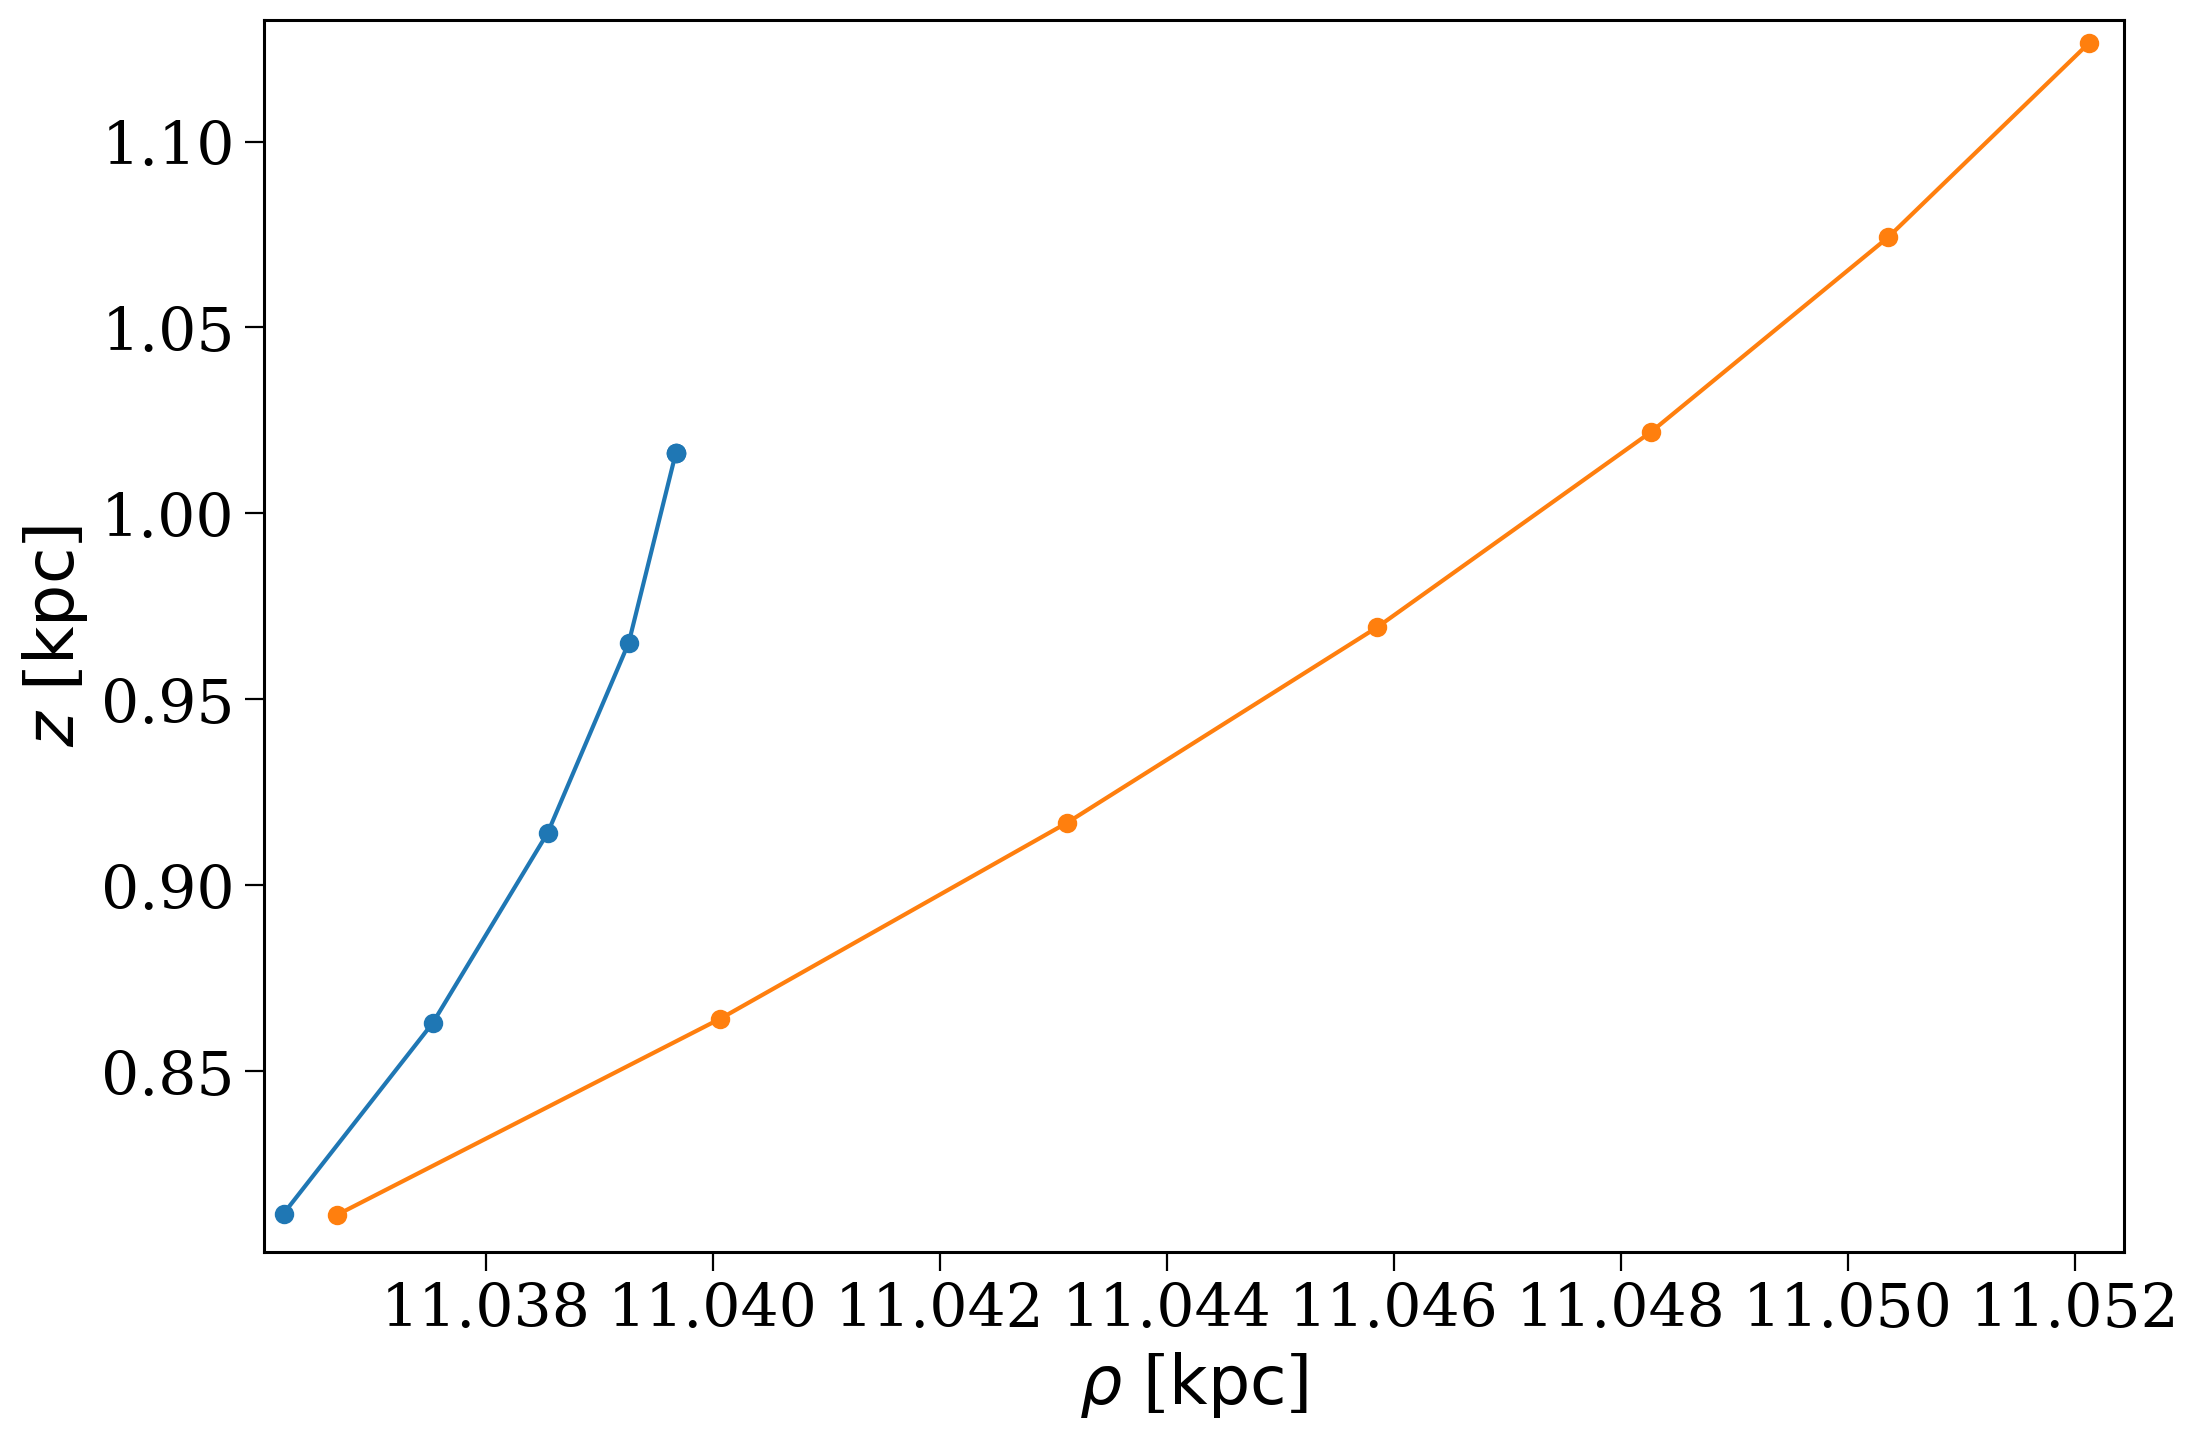

In [58]:
fig, ax = plt.subplots()
t_SN = 4.6
t = np.ceil(t_SN).astype(int) + 2
p.primary_orbits[p.bin_nums == 92][0][:t].cylindrical.plot(['rho', 'z'], axes=ax, marker="o");
particle_orbits[0][:t].cylindrical.plot(['rho', 'z'], axes=ax, marker="o");